# Digital Twin

## Run Parameters

In [1]:
random_seed = 0
show_intermediate_results = True
min_events = 3
min_impressions = 50
min_videos = 5
min_playtime = 10 * 1000
time_horizon = 10 * 60 * 1000
max_impression_duration = 1000*60*60*24
feature_importance_threshold = 0.01
test_fraction = 0.2
search_factor = 4
search_n_candidates = search_factor ** 3 # candidates = search_factor ** n_rounds
search_agg_elimination = True
search_cv = 5
search_scoring = 'neg_root_mean_squared_error' # 'explained_variance'
search_n_jobs = -1
search_verbose = 0

## Setup

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import scipy.stats as ss
import time
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

In [3]:
read_columns = {
    'custom_user_id': str,
    'impression_id': str,
    'video_id': str,
    'video_duration': float,
    'error_code': str,
    'videotime_end': float,
    'duration': float,
    'state': str,
    'video_bitrate': float,
    'video_playback_height': float,
    'client_time': float,
    'time': float,
    'device_class': str,
    # 'm3u8_url': str,
}

states = {
    'playing': 'playing',
    'seeking': 'seeking',
    'end_play_seeking': 'seeking',
    'paused': 'paused',
    'qualitychange': 'qualitychange',
    'qualitychange_pause': 'qualitychange',
    'startup': 'startup',
    'customdatachange': 'drop',
    'error': 'error',
    'ad': 'ad',
    'pause': 'paused',
    'paused_seeking': 'seeking',
    'setup': 'startup',
    'closed': 'closed',
    'buffering': 'rebuffering',
    'rebuffering': 'rebuffering',
    'ready': 'drop',
}

special_features = ['custom_user_id', 'impression_id', 'video_id']

device_classes = {
    'Other': 0,
    'Phone': 1,
    'Tablet': 2,
    'Desktop': 3,
    'TV': 4,
    'Console': 4,
}

model_xgb = XGBRegressor(
    tree_method = "hist",
    n_jobs = 1, 
    max_depth = 100,
    max_leaves = 1000,
    enable_categorical = True,
    n_estimators = 100,
)

parameters_xgb = {
    
    'num_parallel_tree': ss.randint(1, 10),
    'colsample_bytree': ss.uniform(0.5, 0.5),
    'grow_policy': ['depthwise', 'lossguide'],
    'learning_rate': ss.uniform(0, 1),
    'subsample': ss.uniform(0.5, 0.5),
}

model_nn = MLPRegressor(
    solver = 'adam', 
    max_iter = 10000
)

parameters_nn = {
    'hidden_layer_sizes': [
        (40, 20, 10, 5, 2, ),
        (40, 30, 20, 15, 12, 10, 8, 6, 4, 2, ),
        (100, 50, 25, 12, 6, 3, ), 
        (60, 50, 40, 30, 20, 10, ),
        (1000, 100, 10, ),
        (200, 100, 50, 25, 12, 6, 3, 2, ),  
    ],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': ss.loguniform(1e-5, 1e-3),
    'beta_1': ss.uniform(0.5, 0.5),
    'beta_2': ss.uniform(0.9, 0.1),
    'epsilon': ss.loguniform(1e-9, 1e-7),
}

def halving_search(model, parameters):
    return model_selection.HalvingRandomSearchCV(
        estimator = model,
        param_distributions = parameters,
        n_candidates = search_n_candidates,
        factor = search_factor,
        aggressive_elimination = search_agg_elimination,
        cv = search_cv,
        scoring = search_scoring, 
        n_jobs = search_n_jobs,
        verbose = search_verbose,
        random_state=random_seed,
    )

In [4]:
df = pd.read_parquet('dataset', columns=list(read_columns.keys()))
df = df.astype(read_columns)
if show_intermediate_results:
    df.sample(1)

## Data Processing

### Data Cleaning

In [5]:
df_processed = df.replace(['null', 'nan', None, 'None', 'none'], np.nan)
if show_intermediate_results:
    df_processed.sample(1)

In [6]:
# 0, 64, 7618501 clearly are not a single person, they watch the same videos too many times
df_processed = df_processed[~df_processed.custom_user_id.isin([0, '64', 7618501])]

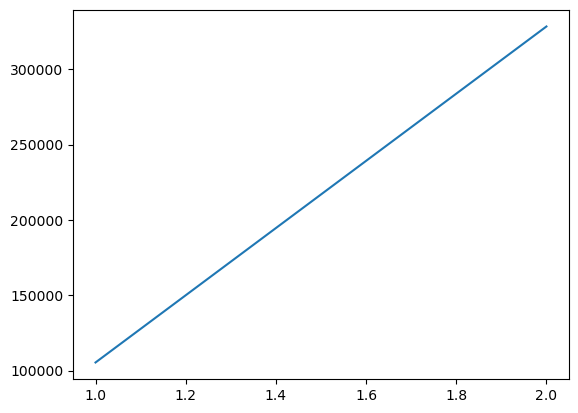

In [7]:
# remove impressions with less than min_events
n_events_per_impression = df_processed.impression_id.value_counts()
small_impressions = n_events_per_impression[n_events_per_impression < min_events]
df_processed = df_processed[~df_processed.impression_id.isin(small_impressions.index)]
if show_intermediate_results:
    small_impressions.value_counts().sort_index().plot()

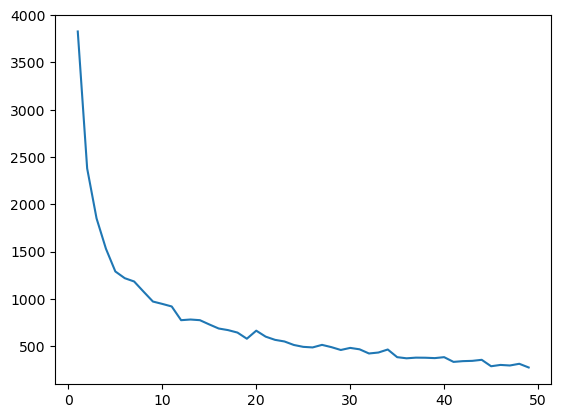

In [8]:
# remove users with less than min_impressions
n_impressions_per_user = df_processed.groupby('custom_user_id').impression_id.nunique()
small_users = n_impressions_per_user[n_impressions_per_user < min_impressions]
df_processed = df_processed[~df_processed.custom_user_id.isin(small_users.index)]
if show_intermediate_results:
    small_users.value_counts().sort_index().plot()

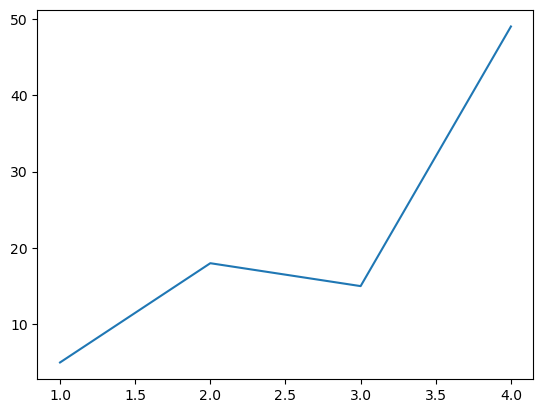

In [9]:
# remove users with too few different videos
n_videos_per_user = df_processed.groupby('custom_user_id').video_id.nunique()
narrow_users = n_videos_per_user[n_videos_per_user < min_videos]
df_processed = df_processed[~df_processed.custom_user_id.isin(narrow_users.index)]
if show_intermediate_results:
    narrow_users.value_counts().sort_index().plot()

In [10]:
# video_duration is not consistent along each video_id, made equal to each video's max video_duration
max_video_duration = df_processed.groupby('video_id').video_duration.max()
video_duration_diff = df_processed.video_id.map(max_video_duration) - df_processed.video_duration
df_processed.video_duration += video_duration_diff
if show_intermediate_results:
    df_processed.groupby('video_id').video_duration.std().sort_values()

In [11]:
df_processed = df_processed.drop(columns='error_code')

In [12]:
# remove impressions with negative videotime_end
df_processed_negative_videotime_end = df_processed[df_processed.videotime_end < 0]
impressions_negative_videotime_end = df_processed_negative_videotime_end.impression_id.unique()
df_processed = df_processed[~df_processed.impression_id.isin(impressions_negative_videotime_end)]
if show_intermediate_results:
    len(impressions_negative_videotime_end)

In [13]:
# a few impressions have videotime_end in timestamp, which makes them useless, dropped together with impressions longer than 24 hours
impressions_too_long = df_processed[df_processed.videotime_end > max_impression_duration].impression_id.unique()
df_processed = df_processed[~df_processed.impression_id.isin(impressions_too_long)]
if show_intermediate_results:
    print(len(impressions_too_long))

53


In [14]:
# duration is sometimes negative, drop affected impressions
impressions_negative_duration = df_processed[df_processed.duration < 0].impression_id.unique()
df_processed = df_processed[~df_processed.impression_id.isin(impressions_negative_duration)]
if show_intermediate_results:
    print(len(impressions_negative_duration))

354


In [15]:
# sometimes videotime_end is greater than video_duration, drop affected impressions
max_videotime_end = df_processed.groupby('video_id').videotime_end.max()
max_video_duration = df_processed.groupby('video_id').video_duration.max()
impressions_long_videotime_end = max_videotime_end[max_videotime_end > max_video_duration].index
df_processed = df_processed[~df_processed.impression_id.isin(impressions_long_videotime_end)]
if show_intermediate_results:
    print(len(impressions_long_videotime_end))

717


### Feature Engineering

In [16]:
# time into hour of day
df_processed['hour'] = pd.to_datetime(df_processed.time, unit='ms').dt.hour

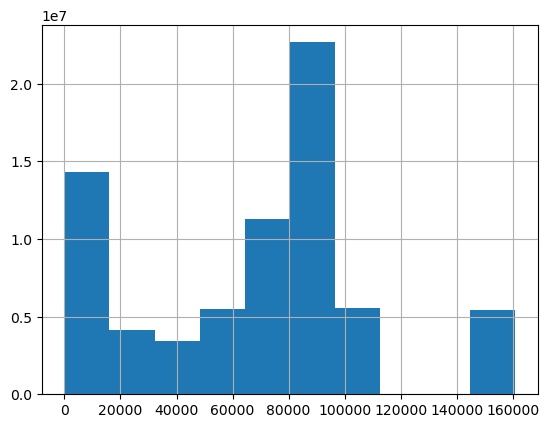

In [17]:
# video_id into video_popularity
video_popularity = df_processed.groupby('video_id').impression_id.nunique()
df_processed['video_popularity'] = df_processed.video_id.map(video_popularity)
if show_intermediate_results:
    df_processed.video_popularity.hist()

In [18]:
# state gets condensed into a lower and more consistent cardinality
df_processed.state = df_processed.state.replace(states)
df_processed = df_processed[df_processed.state != 'drop'].reset_index(drop=True)
# split state in dummies
state_features = pd.get_dummies(df_processed.state, prefix='state').mul(df_processed.duration, axis=0)
df_processed = pd.concat([df_processed, state_features], axis=1)
if show_intermediate_results:
    df_processed.sample(1)

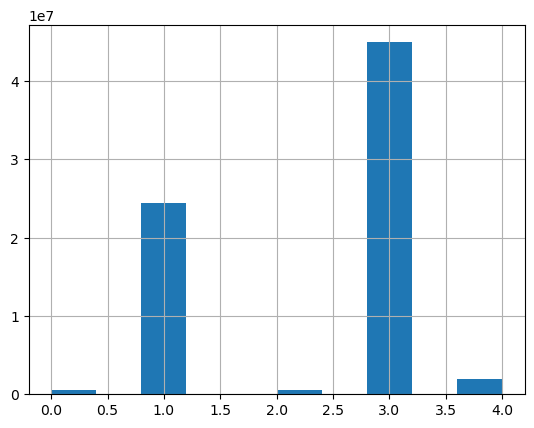

In [19]:
# map device_class by screen size
df_processed['device_class'] = df_processed.device_class.map(device_classes)
if show_intermediate_results:
    df_processed.device_class.hist()

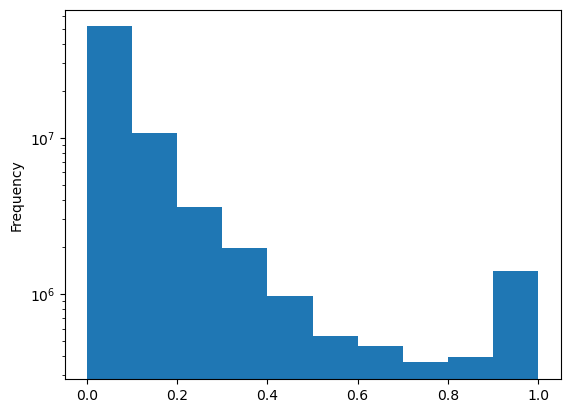

In [20]:
# videotime_end gets divided by video_duration to get engagement as percentage of video watched
df_processed['engagement'] = df_processed.videotime_end / df_processed.video_duration
max_engagement = df_processed.groupby('impression_id').engagement.max()
df_processed.engagement = df_processed.impression_id.map(max_engagement)
# certain impressions have an engagement greater than 1, dropped
df_processed = df_processed[df_processed.engagement <= 1]
if 'engagement' not in special_features:
    special_features.append('engagement')
# bin engagement
if show_intermediate_results:
    df_processed.engagement.plot.hist(logy=True)

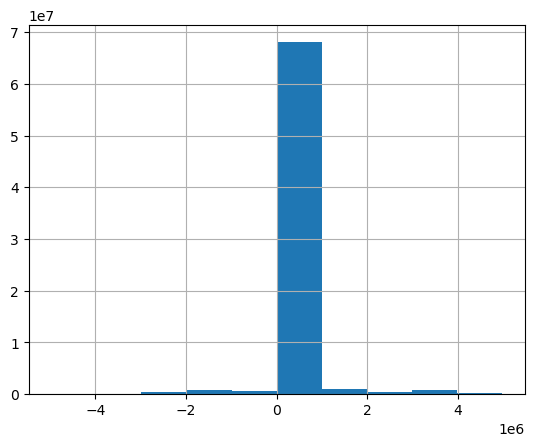

In [21]:
# quality change magnitude
df_processed = df_processed.sort_values(by=['impression_id', 'client_time'])
df_processed['qualitychange'] = df_processed.groupby('impression_id').video_bitrate.diff()
df_processed['qualitychange'] = df_processed['qualitychange'].fillna(0)
if show_intermediate_results:
    df_processed.qualitychange.hist()

/home/itec/emanuele/.conda/envs/ema-310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


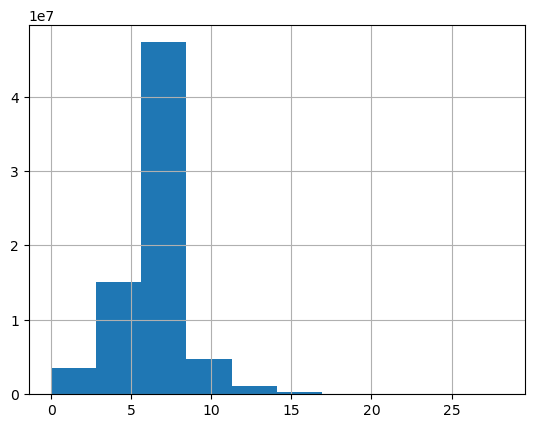

In [22]:
# latency between client and analytics server
df_processed['latency'] = np.abs(df_processed.client_time - df_processed.time)
# df_processed['latency'] = np.log(np.abs(df_processed['latency'])).replace(-np.inf, 0)
if show_intermediate_results:
    np.log(np.abs(df_processed.client_time - df_processed.time)).replace(-np.inf, 0).hist()

In [23]:
df_processed.to_csv('df_processed.csv')

### Compressing (run from here when comparing time horizon)

In [24]:
df_processed = pd.read_csv('df_processed.csv', index_col=0)
if 'engagement' not in special_features:
    special_features.append('engagement')

In [25]:
# compress impressions
df_compressed = df_processed[df_processed.videotime_end <= time_horizon]

df_compressed = df_compressed.groupby('impression_id').agg(
    custom_user_id = pd.NamedAgg(column='custom_user_id', aggfunc='first'),
    video_id = pd.NamedAgg(column='video_id', aggfunc='first'),
    video_duration = pd.NamedAgg(column='video_duration', aggfunc='first'), # not present in CAdViSE 
    device_class = pd.NamedAgg(column='device_class', aggfunc='first'),
    video_popularity = pd.NamedAgg(column='video_popularity', aggfunc='first'),
    hour = pd.NamedAgg(column='hour', aggfunc='median'),
    engagement = pd.NamedAgg(column='engagement', aggfunc='first'),
    startup_delay = pd.NamedAgg(column='state_startup', aggfunc='sum'), # not present in CAdViSE
    
    bitrate_mean = pd.NamedAgg(column='video_bitrate', aggfunc='mean'),
    bitrate_std = pd.NamedAgg(column='video_bitrate', aggfunc='std'),
    bitrate_skew = pd.NamedAgg(column='video_bitrate', aggfunc='skew'),
    bitrate_min = pd.NamedAgg(column='video_bitrate', aggfunc='min'),
    bitrate_median = pd.NamedAgg(column='video_bitrate', aggfunc='median'),
    bitrate_max = pd.NamedAgg(column='video_bitrate', aggfunc='max'),
    resolution_mean = pd.NamedAgg(column='video_playback_height', aggfunc='mean'),
    resolution_std = pd.NamedAgg(column='video_playback_height', aggfunc='std'),
    resolution_skew = pd.NamedAgg(column='video_playback_height', aggfunc='skew'),
    resolution_min = pd.NamedAgg(column='video_playback_height', aggfunc='min'),
    resolution_median = pd.NamedAgg(column='video_playback_height', aggfunc='median'),
    resolution_max = pd.NamedAgg(column='video_playback_height', aggfunc='max'),
    latency_mean = pd.NamedAgg(column='latency', aggfunc='mean'),
    latency_std = pd.NamedAgg(column='latency', aggfunc='std'),
    latency_skew = pd.NamedAgg(column='latency', aggfunc='skew'),
    latency_min = pd.NamedAgg(column='latency', aggfunc='min'),
    latency_median = pd.NamedAgg(column='latency', aggfunc='median'),
    latency_max = pd.NamedAgg(column='latency', aggfunc='max'),
    qualitychange_mean = pd.NamedAgg(column='qualitychange', aggfunc='mean'),
    qualitychange_std = pd.NamedAgg(column='qualitychange', aggfunc='std'),
    qualitychange_skew = pd.NamedAgg(column='qualitychange', aggfunc='skew'),
    qualitychange_max = pd.NamedAgg(column='qualitychange', aggfunc='max'),
    # qualitychange_count = pd.NamedAgg(column='qualitychange', aggfunc=lambda x: x.astype(bool).sum()),
    qualitychange_sum = pd.NamedAgg(column='qualitychange', aggfunc='sum'), 
    paused_mean = pd.NamedAgg(column='state_paused', aggfunc='mean'),
    paused_std = pd.NamedAgg(column='state_paused', aggfunc='std'),
    paused_skew = pd.NamedAgg(column='state_paused', aggfunc='skew'),
    paused_max = pd.NamedAgg(column='state_paused', aggfunc='max'),
    # paused_count = pd.NamedAgg(column='state_paused', aggfunc=lambda x: x.astype(bool).sum()),
    paused_sum = pd.NamedAgg(column='state_paused', aggfunc='sum'),
    playing_mean = pd.NamedAgg(column='state_playing', aggfunc='mean'),
    playing_std = pd.NamedAgg(column='state_playing', aggfunc='std'),
    playing_skew = pd.NamedAgg(column='state_playing', aggfunc='skew'),
    playing_max = pd.NamedAgg(column='state_playing', aggfunc='max'),
    # playing_count = pd.NamedAgg(column='state_playing', aggfunc=lambda x: x.astype(bool).sum()),
    playing_sum = pd.NamedAgg(column='state_playing', aggfunc='sum'),
    seeking_mean = pd.NamedAgg(column='state_seeking', aggfunc='mean'),
    seeking_std = pd.NamedAgg(column='state_seeking', aggfunc='std'),
    seeking_skew = pd.NamedAgg(column='state_seeking', aggfunc='skew'),
    seeking_max = pd.NamedAgg(column='state_seeking', aggfunc='max'),
    # seeking_count = pd.NamedAgg(column='state_seeking', aggfunc=lambda x: x.astype(bool).sum()),
    seeking_sum = pd.NamedAgg(column='state_seeking', aggfunc='sum'), 
    rebuffering_mean = pd.NamedAgg(column='state_rebuffering', aggfunc='mean'),
    rebuffering_std = pd.NamedAgg(column='state_rebuffering', aggfunc='std'),
    rebuffering_skew = pd.NamedAgg(column='state_rebuffering', aggfunc='skew'),
    rebuffering_max = pd.NamedAgg(column='state_rebuffering', aggfunc='max'),
    # rebuffering_count = pd.NamedAgg(column='state_rebuffering', aggfunc=lambda x: x.astype(bool).sum()),
    rebuffering_sum = pd.NamedAgg(column='state_rebuffering', aggfunc='sum'),
)
df_compressed = df_compressed.fillna(0).reset_index()

if show_intermediate_results:
    df_compressed.sample(1)

In [26]:
df_compressed.to_csv('df_compressed.csv')

### Scaling

In [27]:
if special_features[-1] == '10_bins_engagement':
    special_features.pop(-1)

# models benefit from standardized features
scaler = StandardScaler().fit(df_compressed.drop(columns=special_features))
df_standard = pd.DataFrame(
    scaler.transform(df_compressed.drop(columns=special_features)),
    index=df_compressed.index,
    columns=scaler.feature_names_in_
)

# remove outliers and return df_standard to original values
df_standard = df_standard[(df_standard.abs() < 6).all(axis=1)]
df_standard = pd.DataFrame(
    scaler.inverse_transform(df_standard),
    index=df_standard.index,
    columns=scaler.feature_names_in_
)

# refit scaled data without outliers
scaler = StandardScaler().fit(df_standard)
df_standard = pd.DataFrame(
    scaler.transform(df_standard),
    index=df_standard.index,
    columns=scaler.feature_names_in_
)

# reintroduce special features
df_standard = df_standard.join(df_compressed[special_features])
if show_intermediate_results:
    df_standard.describe()

In [28]:
df_standard.to_csv('df_standard.csv')

### User Selection

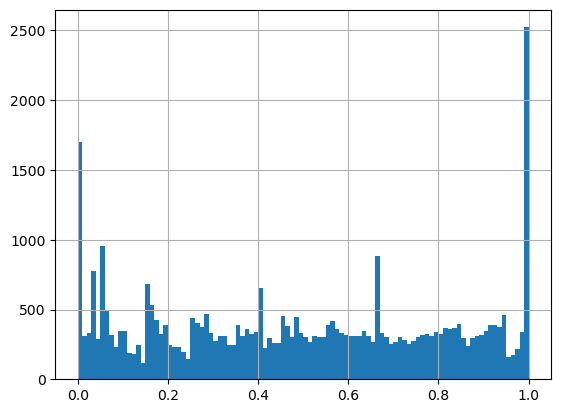

In [29]:
# balance engagement on its lowest bin 
df_standard['10_bins_engagement'] = df_standard.engagement.round(1)
if '10_bins_engagement' not in special_features:
    special_features.append('10_bins_engagement')
# train test split to avoid information leak
df_standard_train, df_standard_test = model_selection.train_test_split(df_standard, test_size=test_fraction, random_state=random_seed)
# balance engagement on its lowest bin
min_engagement_bin = df_standard_train['10_bins_engagement'].value_counts().min()
df_standard_train = df_standard_train.groupby('10_bins_engagement').sample(min_engagement_bin, replace=False, random_state=random_seed)
if show_intermediate_results:
    df_standard_train.engagement.hist(bins=100)

In [30]:
# select users to model
n_impressions_per_user =  df_standard_train.groupby('custom_user_id').engagement.count()
digital_twin_users = n_impressions_per_user[n_impressions_per_user >= min_impressions]
df_standard_train = df_standard_train[df_standard_train.custom_user_id.isin(digital_twin_users.index)]
df_standard_test = df_standard_test[df_standard_test.custom_user_id.isin(digital_twin_users.index)]
if show_intermediate_results:
    print(digital_twin_users)

custom_user_id
0.0           8407
1811068.0       52
1884228.0       94
9985745.0       57
10474852.0     115
11348942.0      65
11430219.0      79
Name: engagement, dtype: int64


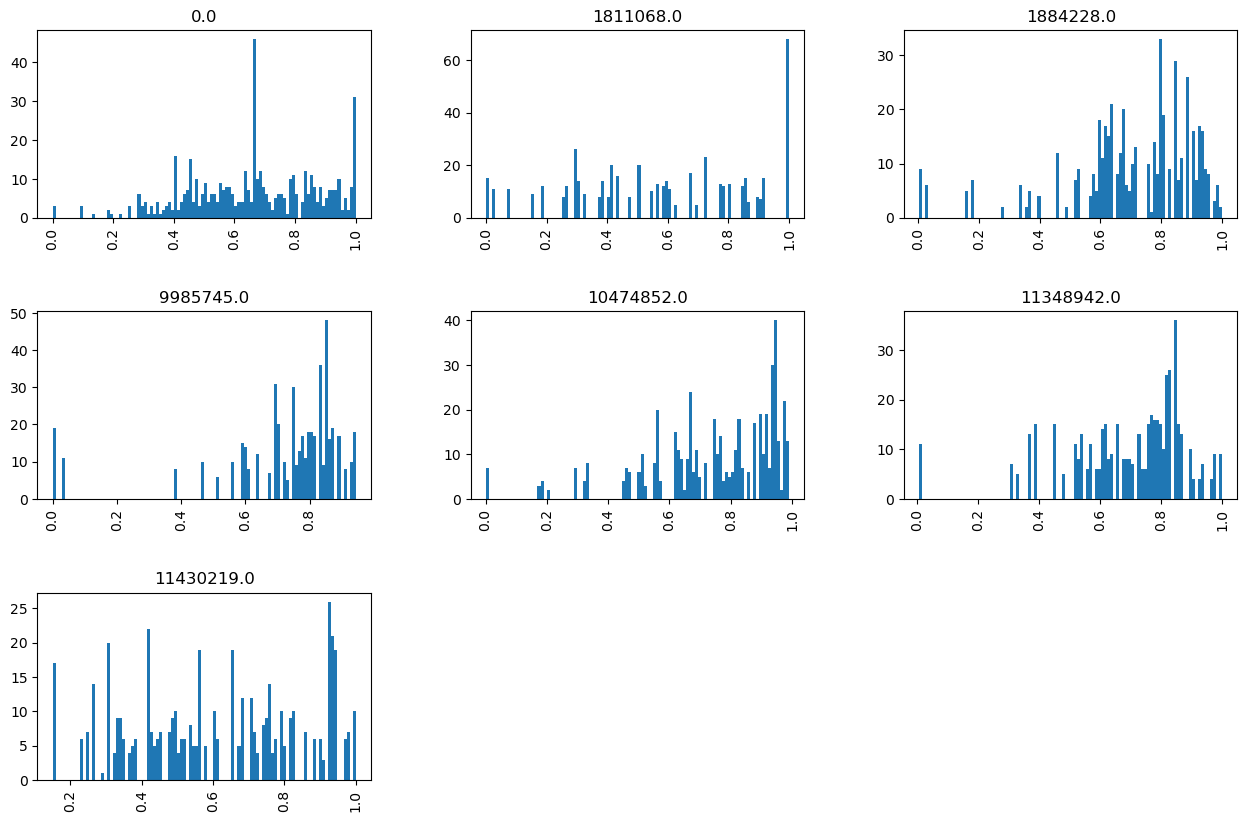

In [31]:
# sample users to have the same number of impressions TODO the train size could probably be smaller (or like n * min_impressions)
df_standard_train = df_standard_train.groupby('custom_user_id').sample(min_impressions * 10, replace=True, random_state=random_seed)
if show_intermediate_results:
    df_standard_train.hist('engagement', bins=100, by='custom_user_id', figsize=(15, 10))
    df_standard_train.custom_user_id.value_counts()

### Feature selection (run from here when comparing feature importance threshold)

In [32]:
# X, y split
X_train = df_standard_train.drop(columns=special_features)
X_test = df_standard_test.drop(columns=special_features)
y_train = df_standard_train.engagement
y_test = df_standard_test.engagement

In [33]:
# dividing feature importances by their sum of correlation coefficients, we highlight features that provide a valuable unique contribution to the prediction
feature_selector = RandomForestRegressor(n_jobs=-1, random_state=random_seed).fit(X_train, y_train)
feature_importances = pd.Series(feature_selector.feature_importances_, index=feature_selector.feature_names_in_)
feature_importances = (feature_importances / np.abs(df_standard_train.corr(method='spearman', numeric_only=True).sum()))
feature_importances = feature_importances.dropna().sort_values(ascending=False)
# normalize feature importances so the threshold can be set a percentage
feature_importances /= feature_importances.sum()
# selecting features with high enough contribution
important_features = feature_importances[feature_importances > feature_importance_threshold]
if show_intermediate_results:
    print(important_features)

video_popularity      0.406290
hour                  0.176080
video_duration        0.070071
latency_min           0.047996
playing_mean          0.024019
qualitychange_sum     0.022515
startup_delay         0.020370
playing_sum           0.018391
playing_std           0.018142
latency_skew          0.014115
bitrate_mean          0.013487
latency_mean          0.012996
playing_max           0.012737
qualitychange_mean    0.011221
latency_median        0.011110
dtype: float64


In [34]:
# drop non important features
model_features = special_features + list(important_features.index)
df_standard_train = df_standard_train[model_features]
df_standard_test = df_standard_test[model_features]
if show_intermediate_results:
    print(model_features)

['custom_user_id', 'impression_id', 'video_id', 'engagement', '10_bins_engagement', 'video_popularity', 'hour', 'video_duration', 'latency_min', 'playing_mean', 'qualitychange_sum', 'startup_delay', 'playing_sum', 'playing_std', 'latency_skew', 'bitrate_mean', 'latency_mean', 'playing_max', 'qualitychange_mean', 'latency_median']


## XGBoost

In [35]:
sensitivities_xgb = pd.DataFrame(
    columns=df_standard_train.drop(columns=special_features).columns + ['_sensitivity'],   
    index=df_standard_train.custom_user_id.unique(),
    dtype=float,
)
results_xgb = pd.DataFrame(
    columns=[ 
        'model',
        'training_time',
        'MAE',
    ],
    index=df_standard_train.custom_user_id.unique()
)
predictions_xgb = pd.DataFrame(
    columns=[
        'true_value',
        'sensitivity_models_prediction',
        'benchmark_model_prediction',
        'engagement_model_prediction',
    ],
    index=df_standard_test.index
)
predictions_xgb.true_value = df_standard_test.engagement

### Sensitivity Models

In [36]:
for user in df_standard_train.custom_user_id.unique():
    # X, y of user
    X_train = df_standard_train[df_standard_train.custom_user_id == user].drop(columns=special_features)
    X_test = df_standard_test[df_standard_test.custom_user_id == user].drop(columns=special_features)
    y_train = df_standard_train[df_standard_train.custom_user_id == user].engagement
    y_test = df_standard_test[df_standard_test.custom_user_id == user].engagement
    # hyperparameter optimization and model training
    start_time = time.time()
    search_xgb = halving_search(model_xgb, parameters_xgb).fit(X_train, y_train)
    # fill predictions
    y_pred = pd.Series(search_xgb.best_estimator_.predict(X_test), index=y_test.index)
    for i, pred in y_pred.items():
        predictions_xgb.at[i, 'sensitivity_models_prediction'] = pred
    # fill results
    results_xgb.at[user, 'model'] = search_xgb.best_estimator_
    results_xgb.at[user, 'training_time'] = time.time() - start_time
    results_xgb.at[user, 'MAE'] = mean_absolute_error(y_test, y_pred)
    # fill sensitivities
    for i, sensitivity in enumerate(results_xgb.loc[user, 'model'].feature_names_in_):
        sensitivities_xgb.at[user, sensitivity + '_sensitivity'] = results_xgb.loc[user, 'model'].feature_importances_[i]    
results_xgb = results_xgb.merge(sensitivities_xgb, left_index=True, right_index=True)
print(f'sensitivity models trained in {results_xgb.training_time.sum()}')
print(f'average MAE of sensitivity models: {results_xgb.MAE.mean()}')
if show_intermediate_results:
    results_xgb

sensitivity models trained in 96.87742757797241
average MAE of sensitivity models: 0.2842907266375791


### Engagement Model

In [37]:
# first run a banchmark model with the same architecture but no sensitivities
# X, y split
X_train = df_standard_train.drop(columns=special_features)
X_test = df_standard_test.drop(columns=special_features)
y_train = df_standard_train.engagement
y_test = df_standard_test.engagement
# hyperparameter optimization and model training
start_time = time.time()
search_xgb = halving_search(model_xgb, parameters_xgb).fit(X_train, y_train)
# fill predictions
y_pred = pd.Series(search_xgb.best_estimator_.predict(X_test), index=y_test.index)
predictions_xgb.benchmark_model_prediction = y_pred
print(f'Time for model training: {time.time() - start_time}')
print(f'MAE of engagement model without sensitivities: {mean_absolute_error(y_test, y_pred)}')

Time for model training: 7.431008815765381
MAE of engagement model without sensitivities: 0.3769725974334187


In [38]:
# now run the same model architecture, but add the preferences as features so you don't need to separate users because their differences are encoded in their sensitivities
df_digitwise_train = df_standard_train.merge(sensitivities_xgb, left_on='custom_user_id', right_index=True)
df_digitwise_test = df_standard_test.merge(sensitivities_xgb, left_on='custom_user_id', right_index=True)

# what if instead of merging, I multiply them by their features
#df_digitwise_train = df_standard_train / sensitivities_xgb

# X, y split
X_train = df_digitwise_train.drop(columns=special_features)
X_test = df_digitwise_test.drop(columns=special_features)
y_train = df_digitwise_train.engagement
y_test = df_digitwise_test.engagement
# hyperparameter optimization and model training
start_time = time.time()
search_xgb = halving_search(model_xgb, parameters_xgb).fit(X_train, y_train)
# fill predictions
y_pred = pd.Series(search_xgb.best_estimator_.predict(X_test), index=y_test.index)
predictions_xgb.engagement_model_prediction = y_pred
print(f'Time for model training: {time.time() - start_time}')
print(f'MAE of engagement model with sensitivities: {mean_absolute_error(y_test, y_pred)}')
if show_intermediate_results:
    predictions_xgb

Time for model training: 9.50321340560913
MAE of engagement model with sensitivities: 0.37536028000751614


## Neural Network

In [39]:
sensitivities_nn = pd.DataFrame(
    columns=df_standard_train.drop(columns=special_features).columns + ['_sensitivity'],   
    index=df_standard_train.custom_user_id.unique(),
    dtype=float,
)
results_nn = pd.DataFrame(
    columns=[ 
        'model',
        'training_time',
        'MAE',
    ],
    index=df_standard_train.custom_user_id.unique()
)
predictions_nn = pd.DataFrame(
    columns=[
        'true_value',
        'sensitivity_models_prediction',
        'benchmark_model_prediction',
        'engagement_model_prediction',
    ],
    index=df_standard_test.index
)
predictions_nn.true_value = df_standard_test.engagement

### Sensitivity Models

In [40]:
for user in df_standard_train.custom_user_id.unique():
    # X, y of user
    X_train = df_standard_train[df_standard_train.custom_user_id == user].drop(columns=special_features)
    X_test = df_standard_test[df_standard_test.custom_user_id == user].drop(columns=special_features)
    y_train = df_standard_train[df_standard_train.custom_user_id == user].engagement
    y_test = df_standard_test[df_standard_test.custom_user_id == user].engagement
    # hyperparameter optimization and model training
    start_time = time.time()
    search_nn = halving_search(model_nn, parameters_nn).fit(X_train, y_train)
    # fill predictions
    y_pred = pd.Series(search_nn.best_estimator_.predict(X_test), index=y_test.index)
    for i, pred in y_pred.items():
        predictions_nn.at[i, 'sensitivity_models_prediction'] = pred
    # fill results
    results_nn.at[user, 'model'] = search_nn.best_estimator_
    results_nn.at[user, 'training_time'] = time.time() - start_time
    results_nn.at[user, 'MAE'] = mean_absolute_error(y_test, y_pred)
    # fill sensitivities
    importances = permutation_importance(
        results_nn.at[user, 'model'], 
        X_train, 
        y_train,
        n_jobs=-1,
    ).importances_mean
    for i, sensitivity in enumerate(results_nn.loc[user, 'model'].feature_names_in_):
        sensitivities_nn.at[user, sensitivity + '_sensitivity'] = importances[i]
results_nn = results_nn.merge(sensitivities_nn, left_index=True, right_index=True)
print(f'sensitivity models trained in {results_nn.training_time.sum()}')
print(f'average MAE of sensitivity models: {results_nn.MAE.mean()}')
if show_intermediate_results:
    results_nn

sensitivity models trained in 36.856743812561035
average MAE of sensitivity models: 0.40413621719433485


### Engagement Model

In [41]:
# first run a banchmark model with the same architecture but no sensitivities
# X, y split
X_train = df_standard_train.drop(columns=special_features)
X_test = df_standard_test.drop(columns=special_features)
y_train = df_standard_train.engagement
y_test = df_standard_test.engagement
# hyperparameter optimization and model training
start_time = time.time()
search_nn = halving_search(model_nn, parameters_nn).fit(X_train, y_train)
# fill predictions
y_pred = pd.Series(search_nn.best_estimator_.predict(X_test), index=y_test.index)
predictions_nn.benchmark_model_prediction = y_pred
print(f'Time for model training: {time.time() - start_time}')
print(f'MAE of engagement model without sensitivities: {mean_absolute_error(y_test, y_pred)}')

Time for model training: 10.703796148300171
MAE of engagement model without sensitivities: 0.4877915597023618


In [42]:
# now run the same model architecture, but add the preferences as features so you don't need to separate users because their differences are encoded in their sensitivities
df_digitwise_train = df_standard_train.merge(sensitivities_nn, left_on='custom_user_id', right_index=True)
df_digitwise_test = df_standard_test.merge(sensitivities_nn, left_on='custom_user_id', right_index=True)

# X, y split
X_train = df_digitwise_train.drop(columns=special_features)
X_test = df_digitwise_test.drop(columns=special_features)
y_train = df_digitwise_train.engagement
y_test = df_digitwise_test.engagement
# hyperparameter optimization and model training
start_time = time.time()
search_nn = halving_search(model_nn, parameters_nn).fit(X_train, y_train)
# fill predictions
y_pred = pd.Series(search_nn.best_estimator_.predict(X_test), index=y_test.index)
predictions_nn.engagement_model_prediction = y_pred
print(f'Time for model training: {time.time() - start_time}')
print(f'MAE of engagement model with sensitivities: {mean_absolute_error(y_test, y_pred)}')
if show_intermediate_results:
    predictions_nn

Time for model training: 7.531790733337402
MAE of engagement model with sensitivities: 0.4893279345299435


## Benchmarks

### Balachandran, 70% accuracy on 10% bins

In [43]:
from sklearn.metrics import accuracy_score
# percentage of impressions where the difference is less than 10%
(np.abs(predictions_xgb.true_value - predictions_xgb.engagement_model_prediction) <= 0.1).mean()

0.19537998641172474

### Shafiq, 87% accuracy on binary "engagement" (whether a user completely downloads a video) after 10 seconds

In [44]:
# set a threshold for what consitutes a "completely downloads a video"
complete_download_threshold = 0.7
# calculate accuracy for binary engagement based on threshold
accuracy_score(
    predictions_xgb.true_value > complete_download_threshold,
    predictions_xgb.engagement_model_prediction > complete_download_threshold
)

0.8767349315733282

### Lebreton, predict for each video % of people that quit "midway through", performance is evaluated with PCC (0.8776) and RMSE (0.09421)

In [45]:
midway_quit_threshold = 0.5
# merge predictions and video_id (3-way merge/join)
lebreton_predictions = df_standard_test.join(
    predictions_xgb
)
lebreton_predictions = lebreton_predictions[['engagement', 'engagement_model_prediction']] > midway_quit_threshold
if show_intermediate_results:
    lebreton_predictions
    
# calculate PCC
print(f'PCC: {lebreton_predictions.engagement.corr(lebreton_predictions.engagement_model_prediction)}')
# calculate RMSE (bool not converted automatically)
from sklearn.metrics import mean_squared_error
lebreton_predictions = lebreton_predictions.replace({True: 1, False: 0})
print(f'RMSE: {mean_squared_error(lebreton_predictions.engagement, lebreton_predictions.engagement_model_prediction, squared = False)}')

PCC: 0.2604050363107507
RMSE: 0.7390207076450929


## Having developed a trustworthy model, we compute the engagement score for CAdViSE sessions

In [46]:
# find sessions to match
df_standard.groupby(['custom_user_id', 'video_id']).impression_id.count().sort_values()

custom_user_id  video_id
3751925.0       1621753        1
8367951.0       1616088        1
                1616089        1
                1619655        1
                1621754        1
                            ... 
0.0             1600482     2930
                1592627     3225
                1606422     3548
                1600466     4005
                1600481     5270
Name: impression_id, Length: 249430, dtype: int64

In [47]:
df_standard = df_standard[df_standard.video_id != 1575150]

In [48]:
df_standard[(df_standard.custom_user_id == 8254984) & (df_standard.video_id == 1619994)]

,video_duration,device_class,video_popularity,hour,startup_delay,bitrate_mean,bitrate_std,bitrate_skew,bitrate_min,bitrate_median,bitrate_max,resolution_mean,resolution_std,resolution_skew,resolution_min,resolution_median,resolution_max,latency_mean,latency_std,latency_skew,latency_min,latency_median,latency_max,qualitychange_mean,qualitychange_std,qualitychange_skew,qualitychange_max,qualitychange_sum,paused_mean,paused_std,paused_skew,paused_max,paused_sum,playing_mean,playing_std,playing_skew,playing_max,playing_sum,seeking_mean,seeking_std,seeking_skew,seeking_max,seeking_sum,rebuffering_mean,rebuffering_std,rebuffering_skew,rebuffering_max,rebuffering_sum,custom_user_id,impression_id,video_id,engagement,10_bins_engagement
17951,-0.235602,0.787094,-1.198869,1.057896,0.137723,0.324332,0.448076,-0.414588,-0.428004,0.690514,0.335563,0.261298,0.412973,-0.320536,-0.465914,0.674016,0.286828,-0.018828,-0.083365,1.076084,-0.015516,-0.015519,-0.044626,0.633626,0.810984,0.879381,0.916715,0.977468,-0.083136,-0.086987,1.227906,-0.087455,-0.090307,-0.189016,-0.114727,0.074780,-0.113059,-0.295936,-0.066929,-0.075400,-0.472247,-0.075713,-0.078578,-0.049928,-0.046242,-0.230391,-0.048735,-0.062071,8254984.0,034e75b1-d80d-42ba-bd02-a7d8b0e34e86,1619994,0.000933,0.0
25170,-0.235602,0.787094,-1.198869,-0.177724,-0.169386,0.669463,-0.104434,-1.365964,-0.428004,0.690514,0.335563,0.656843,-0.168837,-1.256562,-0.465914,0.674016,0.286828,-0.019157,-0.092880,-0.907866,-0.015207,-0.015193,-0.046731,-0.017839,0.229936,1.751807,0.916715,0.977468,-0.089968,-0.094245,0.735647,-0.093516,-0.095528,0.106505,1.230519,1.292174,1.938365,0.346172,1.052692,1.409224,2.241918,1.416965,1.412882,-0.049928,-0.046242,-0.230391,-0.048735,-0.062071,8254984.0,04a147eb-0d07-4674-9757-18701516aa32,1619994,0.035967,0.0
25397,-0.235602,0.787094,-1.198869,1.057896,0.047327,-1.401324,-1.200765,0.531786,-0.428004,-1.315121,-1.662043,-1.716424,-1.323307,0.610570,-0.465914,-1.612517,-2.121732,-0.019329,-0.091834,0.657124,-0.015403,-0.015428,-0.046731,-0.452149,-0.769908,-0.621853,-0.811360,-0.694642,-0.090141,-0.094360,0.680470,-0.093728,-0.096325,-0.425869,-0.495557,0.716360,-0.540817,-0.438980,-0.066929,-0.075400,-0.472247,-0.075713,-0.078578,-0.049928,-0.046242,-0.230391,-0.048735,-0.062071,8254984.0,04acbcf4-583a-4457-8cd3-ee054e0ca779,1619994,0.029834,0.0
30678,-0.235602,0.787094,-1.198869,-0.383661,-0.078990,0.707810,-0.195133,-1.584144,-0.428004,0.690514,0.335563,0.700792,-0.264346,-1.471223,-0.465914,0.674016,0.286828,-0.019171,-0.092862,-0.902195,-0.015222,-0.015193,-0.046743,-0.090224,0.142821,1.978361,0.916715,0.977468,-0.089978,-0.094312,0.241723,-0.093626,-0.095372,-0.416315,-0.441511,1.272556,-0.372037,-0.365484,-0.054938,-0.067242,0.815217,-0.069545,-0.059410,-0.049928,-0.046242,-0.230391,-0.048735,-0.062071,8254984.0,05aea4e9-bc07-4589-908e-de92cf936ef2,1619994,0.021369,0.0
37476,-0.235602,0.787094,-1.198869,-0.795534,-0.371099,-0.250887,1.317881,0.531786,-0.428004,-0.312303,0.335563,-0.397943,1.328904,0.610570,-0.465914,-0.469250,0.286828,-0.019322,-0.092759,-0.289299,-0.015290,-0.015373,-0.046915,-0.452149,-0.769908,-0.621853,-0.811360,-0.694642,-0.090396,-0.094548,-0.641155,-0.093840,-0.096432,-0.467258,-0.592940,-0.654911,-0.624286,-0.450483,-0.066929,-0.075400,-0.472247,-0.075713,-0.078578,-0.049928,-0.046242,-0.230391,-0.048735,-0.062071,8254984.0,06f03e75-b818-4b29-8c83-f557459a33a1,1619994,0.126304,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340938,-0.235602,0.787094,-1.198869,-0.589597,-0.369915,-1.401324,-1.200765,0.531786,-0.428004,-1.315121,-1.662043,-1.716424,-1.323307,0.610570,-0.465914,-1.612517,-2.121732,-0.019338,-0.093017,-0.289299,-0.015284,-0.015389,-0.046951,-0.452149,-0.769908,-0.621853,-0.811360,-0.694642,-0.090396,-0.094548,-0.641155,-0.093840,-0.096432,-0.467301,-0

In [49]:
# X, y split
X_train = df_standard_train.drop(columns=special_features)
X_test = df_standard_test.drop(columns=special_features)
y_train = df_standard_train.engagement
y_test = df_standard_test.engagement

cadvise = pd.read_csv('DT_dataset_ARTEMIS_final.csv')
cadvise = cadvise[~cadvise.content.str.contains('artemis')]
cadvise = cadvise.drop(columns=['lalisa ladder', 'players', 'content', 'run', 'delay'])

# add a new benchmark network from high bandwidth scenarios
cadvise_new = pd.read_csv('DT_dataset_ARTEMIS_new.csv')

cadvise = pd.concat([
    cadvise,
    cadvise_new,
])

# combinations of parameters
scenario_features = ['segment size (s)', 'abr', 'network']

# sample 100 occurrences of each scenario combination
cadvise = cadvise.groupby(scenario_features).sample(100, replace=True, random_state=random_seed)

X_train_only_columns = X_train.columns.difference(cadvise.columns)
cadvise_only_columns = cadvise.columns.difference(X_train.columns)

# columns that are in X_train and not in CAdViSE get filled with the median value from training data
X_train_only_medians = X_train[X_train_only_columns].median()
for col in X_train_only_medians.index:
    cadvise[col] = X_train_only_medians[col]
    
# certain parameters can be chosen directly instead of using their median to see how they impact the results
experiment_parameters = {
    'device_class': 3,
    'video_duration': 60 * 60 * 1000,
    'video_popularity': 100,
    'startup_delay': 1000,
    'hour': 20,
}
for col in experiment_parameters:
    cadvise[col] = experiment_parameters[col]
    
# columns that are in CAdViSE and not in X_train get removed
cadvise_parameters = cadvise[cadvise_only_columns]
cadvise = cadvise.drop(columns=cadvise_only_columns)

# add empty columns for missing columns (that were filtered out in feature selection)
missing_columns = pd.Index(scaler.feature_names_in_).difference(cadvise.columns)
cadvise[missing_columns] = 0
# reorder columns as in X_train for scaler
cadvise = cadvise[scaler.feature_names_in_]
# scale cadvise features
cadvise = pd.DataFrame(
    scaler.transform(cadvise),
    index=cadvise.index,
    columns=scaler.feature_names_in_
)
# remove empty columns
cadvise = cadvise.drop(columns=missing_columns)

# add a sampled user sentivities set to every cadvise impression
sensitivities_for_cadvise = sensitivities_xgb.sample(len(cadvise), replace=True, random_state=random_seed).set_index(cadvise.index)
cadvise = pd.concat([
    cadvise,
    sensitivities_for_cadvise
], axis=1).astype(float)

# reorder columns as in XGBoost model
cadvise = cadvise[search_xgb.best_estimator_.get_booster().feature_names]

# predict engagement
cadvise['engagement'] = search_xgb.best_estimator_.predict(cadvise)

# add back scenario features
cadvise = cadvise.join(cadvise_parameters[scenario_features])

if show_intermediate_results:
    cadvise.groupby(scenario_features).engagement.describe()

In [50]:
# choose a parameter to compare engagement
feature_to_compare = 'segment size (s)'

# put feature_to_compare as last so it's easy to check
scenario_features.remove(feature_to_compare)
scenario_features.append(feature_to_compare)

cadvise_combinations_engagement = cadvise.groupby(scenario_features).engagement.describe()
cadvise_combinations_engagement

count      mean       std  \
abr        network        segment size (s)                               
bola       amazonfcc      2                 1104.0  0.646776  0.083056   
           cascade20      2                 1117.0  0.655692  0.084756   
l2a        amazonfcc      1                  166.0  0.661098  0.074047   
                          2                  129.0  0.661071  0.082978   
           cascade20      1                  184.0  0.666499  0.067733   
                          2                  110.0  0.659631  0.080334   
           cascade5       1                  124.0  0.648894  0.079227   
                          2                  112.0  0.660871  0.080692   
           fixed          1                  126.0  0.657710  0.084585   
           fixedhighest   1                 1306.0  0.667915  0.088760   
           high_bandwidth 2                 1078.0  0.690557  0.106306   
           low_bandwidth  2                 1204.0  0.664347  0.104186   
           lowandhigh     2                  168.0  0.672506  0.093850   
           lte            1                  132.0  0.661093  0.078450   
                          2                  108.0  0.661567  0.084620   
lolp       cascade5       2                  144.0  0.666913  0.077533   
           lte            2                  148.0  0.674944  0.074871   
throughput amazonfcc      2                 1032.0  0.660156  0.073303   
           cascade20      2                 1388.0  0.646798  0.079809   

                                                 min       25%       50%  \
abr        network        segment size (s)                                 
bola       amazonfcc      2                 0.405675  0.531140  0.701128   
           cascade20      2                 0.410230  0.533348  0.702391   
l2a        amazonfcc      1                 0.487668  0.691185  0.700746   
                          2                 0.526724  0.538063  0.705233   
           cascade20      1                 0.487668  0.672129  0.697860   
                          2                 0.487668  0.531140  0.704743   
           cascade5       1                 0.488599  0.531140  0.700737   
                          2                 0.526830  0.537001  0.709857   
           fixed          1                 0.476113  0.537010  0.703351   
           fixedhighest   1                 0.515618  0.527811  0.721948   
           high_bandwidth 2                 0.540533  0.543151  0.765392   
           low_bandwidth  2                 0.423937  0.575029  0.702829   
           lowandhigh     2                 0.495600  0.552741  0.716157   
           lte            1                 0.530094  0.538955  0.705461   
                          2                 0.527811  0.538824  0.711016   
lolp       cascade5       2                 0.530132  0.694320  0.709962   
           lte            2                 0.524011  0.704345  0.710452   
throughput amazonfcc      2                 0.509661  0.672022  0.700457   
           cascade20      2                 0.401385  0.661258  0.672122   

                                                 75%       max  
abr        network        segment size (s)                      
bola       amazonfcc      2                 0.704268  0.718855  
           cascade20      2                 0.709467  0.731139  
l2a        amazonfcc      1                 0.704377  0.706649  
                          2                 0.712603  0.772031  
           cascade20      1                 0.703224  0.706663  
                          2                 0.710964  0.717357  
           cascade5       1                 0.704425  0.711223  
                          2                 0.711452  0.716949  
           fixed          1                 0.709899  0.819717  
           fixedhighest   1                 0.722766  0.722961  
           high_bandwidth 2                 0.768631  0.771207  
           low_bandwidth  2                 0.74

In [51]:
# TODO add graphs about impact of network trace, abr and bitrate ladder